# Linear-time Closed itemset Miner (LCM)

## Introduction

L’algorithme LCM (Linear-time Closed itemset Miner) est utilisé pour trouver des itemsets fermés fréquents dans une base de données\
transactionnelle. Un itemset fermé est un ensemble d’éléments qui apparaissent ensemble dans un certain nombre de transactions, \
et aucun super-ensemble de cet itemset n’a la même fréquence

## Principe

1. **Génération des itemsets fréquents** : L’algorithme commence par générer tous les itemsets fréquents.
2. **Vérification de la fermeture** : Pour chaque itemset fréquent, il vérifie s’il est fermé. Un itemset est fermé si aucun de ses super-ensembles n’a la même fréquence.
3. **Pruning (élagage)** : L’algorithme élimine les itemsets non fermés pour ne conserver que les itemsets fermés fréquents.

## Pseudo code 

```
Algorithme LCM(D, minsup)
    F = ensemble vide
    pour chaque item i dans D
        C = {i}
        LCM_recursif(C, D, minsup, F)
    retourner F

fonction LCM_recursif(C, D, minsup, F)
    si support(C, D) < minsup
        retourner
    si estFerme(C, D)
        ajouter C à F
    pour chaque item i dans D
        si i > dernier item de C
            C' = C ∪ {i}
            LCM_recursif(C', D, minsup, F)

fonction estFerme(C, D)
    pour chaque super-ensemble S de C
        si support(S, D) == support(C, D)
            retourner faux
    retourner vrai
```

## Implémentation en Python

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool 

In [2]:
def support(itemset, transactions):
    return sum(1 for transaction in transactions if itemset.issubset(transaction))

def est_ferme(itemset, transactions):
    itemset_support = support(itemset, transactions)
    for transaction in transactions:
        if itemset.issubset(transaction):
            for item in transaction:
                if item not in itemset:
                    new_itemset = itemset | {item}
                    if support(new_itemset, transactions) == itemset_support:
                        return False
    return True

def lcm_recursif(itemset, transactions, minsup, result):
    if support(itemset, transactions) < minsup:
        return
    if est_ferme(itemset, transactions):
        result.append(itemset)
    for item in set().union(*transactions):
        if item > max(itemset, default=0):
            new_itemset = itemset | {item}
            lcm_recursif(new_itemset, transactions, minsup, result)

def lcm(transactions, minsup):
    result = []
    for item in tqdm(set().union(*transactions)):
        lcm_recursif({item}, transactions, minsup, result)
    return result


def generate_rules(frequent_itemsets, transactions, min_confidence):
    rules = []
    for itemset in frequent_itemsets:
        for item in itemset:
            antecedent = itemset - {item}
            if antecedent:
                confidence = support(itemset, transactions) / support(antecedent, transactions)
                lift = support(itemset, transactions) / (support(antecedent, transactions)*support({item}, transactions))
                if confidence >= min_confidence:
                    rules.append((antecedent, {item}, confidence, lift))
    return rules

In [3]:
#data = pd.read_csv("https://www.biz.uiowa.edu/faculty/jledolter/DataMining/lastfm.csv")
raw_data = pd.read_csv("lastfm.csv")

In [4]:
raw_data.head()

,user,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany


In [5]:
data = raw_data[['user','artist']]

In [6]:
data.head()

,user,artist
0,1,red hot chili peppers
1,1,the black dahlia murder
2,1,goldfrapp
3,1,dropkick murphys
4,1,le tigre


In [7]:
int(data.duplicated().sum())

2

In [8]:
data[data.duplicated()]

,user,artist
102446,6980,m.i.a.
143746,9753,james brown


In [9]:
records = []
for i in data['user'].unique():
    records.append(list(data[data['user'] == i]['artist'].values))

In [10]:
print(f"Nombre total de transaction : {len(records)}")

Nombre total de transaction : 15000


In [11]:
records[0]

['red hot chili peppers',
 'the black dahlia murder',
 'goldfrapp',
 'dropkick murphys',
 'le tigre',
 'schandmaul',
 'edguy',
 'jack johnson',
 'eluveitie',
 'the killers',
 'judas priest',
 'rob zombie',
 'john mayer',
 'the who',
 'guano apes',
 'the rolling stones']

In [12]:
def compute_all_item_frequency(transactions, items_list):
    result = {}
    result["item"] = []
    result["freq"] = []
    for item in items_list:
        result["item"].append(item)
        result["freq"].append(support({item}, transactions))
    return result

In [13]:
items_list = data['artist'].unique()

In [14]:
freq = compute_all_item_frequency(records, items_list)

In [15]:
freq = pd.DataFrame(freq)

In [16]:
freq.sort_values(by='freq', ascending=False).head(10)

,item,freq
38,radiohead,2704
129,the beatles,2668
170,coldplay,2378
0,red hot chili peppers,1786
66,muse,1711
71,metallica,1670
58,pink floyd,1574
314,linkin park,1473
9,the killers,1473
475,nirvana,1473


In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'radiohead'),
  Text(1, 0, 'the beatles'),
  Text(2, 0, 'coldplay'),
  Text(3, 0, 'red hot chili peppers'),
  Text(4, 0, 'muse'),
  Text(5, 0, 'metallica'),
  Text(6, 0, 'pink floyd'),
  Text(7, 0, 'linkin park'),
  Text(8, 0, 'the killers'),
  Text(9, 0, 'nirvana'),
  Text(10, 0, 'system of a down'),
  Text(11, 0, 'death cab for cutie'),
  Text(12, 0, 'led zeppelin'),
  Text(13, 0, 'queen'),
  Text(14, 0, 'placebo'),
  Text(15, 0, 'daft punk'),
  Text(16, 0, 'the cure'),
  Text(17, 0, 'arctic monkeys'),
  Text(18, 0, 'depeche mode'),
  Text(19, 0, 'david bowie')])

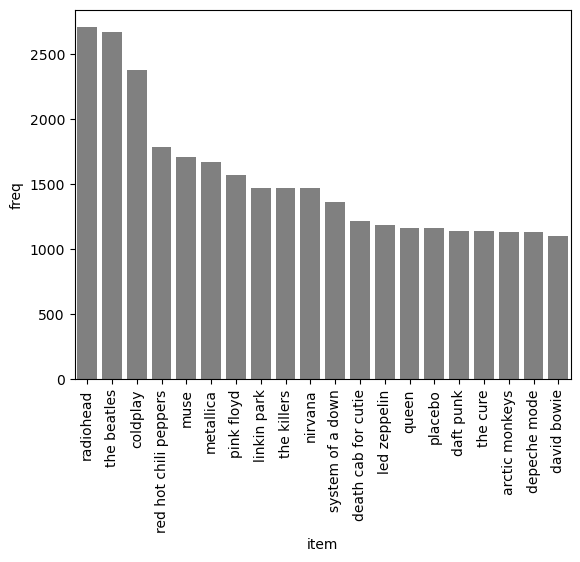

In [18]:
sns.barplot(freq.sort_values(by='freq', ascending=False).head(20), x='item', y="freq", color= "grey")
plt.xticks(rotation = 90)

In [19]:
min_confidence = 0.3
minsup=0.01*len(records[:1000])

In [20]:
minsup

10.0

In [21]:
itemsets_fermes = lcm(records[:1000], minsup)

100%|██████████| 1004/1004 [34:39<00:00,  2.07s/it] 


In [22]:
print("Itemset Fermés : ")
for i, itemset in enumerate(itemsets_fermes):
	print(f"{itemset} : {support(itemset, records[:1000])}")

Itemset Fermés : 
{'pixies'} : 48
{'sonic youth', 'pixies'} : 14
{'pixies', 'the white stripes'} : 12
{'tom waits', 'pixies'} : 11
{'the rolling stones', 'pixies'} : 10
{'pixies', 'the beatles'} : 23
{'the velvet underground', 'pixies', 'the beatles'} : 11
{'the kinks', 'pixies'} : 10
{'the velvet underground', 'pixies'} : 15
{'radiohead', 'pixies'} : 22
{'sonic youth', 'radiohead', 'pixies'} : 11
{'radiohead', 'pixies', 'the beatles'} : 11
{'the postal service'} : 31
{'alexisonfire'} : 16
{'sum 41'} : 36
{'system of a down', 'sum 41'} : 13
{'the offspring', 'sum 41'} : 13
{'kate nash'} : 13
{'george michael'} : 12
{'the smashing pumpkins'} : 79
{'tool', 'the smashing pumpkins'} : 16
{'the strokes', 'the smashing pumpkins'} : 10
{'the smashing pumpkins', 'the white stripes'} : 13
{'u2', 'the smashing pumpkins'} : 13
{'arcade fire'} : 54
{'sufjan stevens', 'arcade fire'} : 15
{'modest mouse', 'arcade fire'} : 13
{'beirut', 'arcade fire'} : 12
{'coldplay', 'arcade fire'} : 12
{'broken so

In [23]:
rules = generate_rules(itemsets_fermes, records, min_confidence)

In [24]:
rules = pd.DataFrame(rules, columns=["antecedent", "consequent", "confidence", "lift"])

In [25]:
rules.sort_values(by='confidence', ascending=False).head(10)

,antecedent,consequent,confidence,lift
373,"{u2, keane}",{coldplay},0.776786,0.000327
1180,"{radiohead, tom waits, the rolling stones}",{the beatles},0.722222,0.000271
38,"{beyoncé, kelly clarkson}",{rihanna},0.716049,0.001108
20,"{the smashing pumpkins, björk}",{radiohead},0.713115,0.000264
1162,"{the cure, sigur rós}",{radiohead},0.697368,0.000258
270,"{oasis, death cab for cutie}",{coldplay},0.695312,0.000292
389,"{red hot chili peppers, coldplay, the smashing...",{radiohead},0.682353,0.000252
102,"{bob dylan, the who}",{the beatles},0.681818,0.000256
495,"{led zeppelin, the rolling stones, the doors}",{pink floyd},0.680412,0.000432
567,"{system of a down, guns n roses}",{metallica},0.678161,0.000406


In [26]:
len(itemsets_fermes)

2653

In [27]:
np.sum([est_ferme(itemsets, records[:1000]) for itemsets in itemsets_fermes])/len(itemsets_fermes)

1.0